### Demonstration of [`dynamic_characterization`](https://github.com/brightway-lca/dynamic_characterization) package

`dynamic_characterization` works with a simple, common input format for dynamic inventories, using `pandas.DataFrame`:

| date | amount | flow | activity |
|-------|-------|------|----------|
| 101   | 33    | 1    | 2        |
| 312   | 21    | 4    | 2        |

The dynamic inventory can be generated with [`bw_temporalis`](https://github.com/brightway-lca/bw_temporalis) (dynamic LCA in Brightway) or [`bw_timex`](https://github.com/brightway-lca/bw_timex) (time-explicit LCA in Brightway) but can also be imported by the user from a different tool.



Each characterization function takes one row of this dynamic inventory dataframe (i.e. one emission at one point in time) and transforms it according to some metric. 
The output generated by applying a very simple function to both rows of the input dataframe could look like:

| date | amount | flow | activity |
|------|--------|------|----------|
| 101  | 33     | 1    | 2        |
| 102  | 25     | 1    | 2        |
| 103  | 20     | 1    | 2        |
| 312  | 21     | 4    | 2        |
| 313  | 20     | 4    | 2        |
| 314  | 19     | 4    | 2        |

### 1) Use package as standalone

Let's try this for the simple system of:


| date | amount | flow | activity |
|-------|-------|------|----------|
| 15-12-2020   | 10    | 1 (CO2)   | 2        |
| 20-12-2020  | 20    | 1 (CO2)    | 2        |
| 25-05-2022 | 50    | 2 (CH4)    | 4        |

In [1]:
import pandas as pd
import numpy as np

# defining a dummy dynamic inventory from above
dynamic_inventory_df = pd.DataFrame(
        data={
            "date": pd.Series(
                data=[
                    "15-12-2020",
                    "20-12-2020",
                    "25-05-2022",
                ],
                dtype="datetime64[s]",
            ),
            "amount": pd.Series(data=[10.0, 20.0, 50.0], dtype="float64"),
            "flow": pd.Series(data=[1, 1, 3], dtype="int"),
            "activity": pd.Series(data=[2, 2, 4], dtype="int"),
        }
    )

In [2]:
dynamic_inventory_df

,date,amount,flow,activity
0,2020-12-15,10.0,1,2
1,2020-12-20,20.0,1,2
2,2022-05-25,50.0,3,4


In [3]:
from dynamic_characterization import characterize
from dynamic_characterization.ipcc_ar6 import characterize_co2, characterize_ch4

df_characterized = characterize(
        dynamic_inventory_df,
        metric="radiative_forcing", # could also be GWP
        characterization_functions={
            1: characterize_co2,
            3: characterize_ch4,
        },
        time_horizon=4, #years
    )

In [4]:
df_characterized #[W/m-2*ppb-1]

,date,amount,flow,activity
0,2021-12-15 05:49:12,1.647203e-14,1,2
1,2021-12-20 05:49:12,3.294405e-14,1,2
2,2022-12-15 11:38:24,1.546265e-14,1,2
3,2022-12-20 11:38:24,3.092531e-14,1,2
4,2023-05-25 05:49:12,9.611168e-12,3,4
5,2023-12-15 17:27:36,1.463745e-14,1,2
6,2023-12-20 17:27:36,2.927490e-14,1,2
7,2024-05-24 11:38:24,8.830221e-12,3,4
8,2025-05-24 17:27:36,8.112729e-12,3,4


In [5]:
df_characterized = characterize(
        dynamic_inventory_df,
        metric="GWP", 
        characterization_functions={
            1: characterize_co2,
            3: characterize_ch4,
        },
        time_horizon=500, #years
    )

df_characterized #[kg CO2-eq]

,date,amount,flow,activity
0,2020-12-15,10.000000,1,2
1,2020-12-20,20.000000,1,2
2,2022-05-25,378.376822,3,4


### 2) Use via Brightway

This package can be easily used with [Brightway](https://docs.brightway.dev/en/latest/), directly matching the dynamic_characterization functions to the biosphere3 flows that are part of your chosen method. [`bw_temporalis`](https://github.com/brightway-lca/bw_temporalis) or [`bw_timex`](https://github.com/brightway-lca/bw_timex) are the two BW packages that can provide inventories with timestamps.


Let's see how this works with brightway and `bw_temporalis` and the following dummy system with some delayed emission of CO2 and CH4:


```mermaid
flowchart LR

subgraph foreground[" "]
    A(Process A\n2024):::fg
end

subgraph biosphere[" "]
    CO2(CO2):::b
    CH4(CH4):::b
end


A -.->|"amounts: [33%, 33%, 33%] * 9 kg\n dates: [0, +10, +20]" years|CO2
A-.->|"amounts: [50%, 50%] * 0.04 kg\n dates: [0,+5]" years|CH4



classDef fg color:#222832, fill:#3fb1c5, stroke:none;
classDef b color:#222832, fill:#9c5ffd, stroke:none;
style foreground fill:none, stroke:none;
style biosphere fill:none, stroke:none;

```

In [6]:
import bw2data as bd
import bw2io as bi

bi.remote.install_project('ecoinvent-3.10-biosphere', 'my_demo', overwrite_existing=True) # no license required for biosphere data 
bd.projects.set_current("my_demo") 
print(bd.databases)
len(bd.Database("ecoinvent-3.10-biosphere"))

Restoring project backup archive - this could take a few minutes...
Restored project: my_demo
Databases dictionary with 1 object(s):
	ecoinvent-3.10-biosphere


4362

Select some biosphere flows:

In [7]:
co2 = bd.get_node(name="Carbon dioxide, fossil", categories=("air",))
ch4 = bd.get_node(name="Methane, fossil", categories=("air",))

c:\Users\MULLERA\AppData\Local\anaconda3\envs\timex_temporalis_local\Lib\site-packages\bw2data\utils.py:394: UserWarning: Given search criteria very broad; try to specify at least a database
  warnings.warn(


Add dummy system and temporal information

In [8]:
from bw_temporalis import TemporalDistribution

bd.Database("test_db").write(
    {
        ("test_db", "A"): {
            "name": "A",
            "location": "somewhere",
            "reference product": "A",
            "exchanges": [
                {
                    "amount": 1,
                    "type": "production",
                    "input": ("test_db", "A"),
                },
                {
                    "amount": 9,
                    "type": "biosphere",
                    "input": co2,
                    "temporal_distribution": TemporalDistribution(
                        np.array(
                            [0, 10, 20], dtype="timedelta64[Y]"
                        ),  # CO2 emissions at 0, 10 and 20 years from today (01.10.2024)
                        np.array([1 / 3, 1 / 3, 1 / 3]),
                    ),
                },
                {
                    "amount": 0.04,
                    "type": "biosphere",
                    "input": ch4,
                    "temporal_distribution": TemporalDistribution(
                        np.array(
                            [0, 5], dtype="timedelta64[Y]"
                        ),  # CH4 emissions at 0, 5 years from today (01.10.2024)
                        np.array([1 / 2, 1 / 2]),
                    ),
                },
            ],
        },
    }
)

Not able to determine geocollections for all datasets. This database is not ready for regionalization.


100%|██████████| 1/1 [00:00<00:00, 1838.80it/s]

Vacuuming database 


Use bw_temporalis to do a dynamic LCA and create the desired dataframe of the dynamic inventory:

In [9]:
import bw2calc as bc
from bw_temporalis import TemporalisLCA
method = ('EF v3.1', 'climate change', 'global warming potential (GWP100)') # tuple to identify method
lca = bc.LCA({("test_db", "A"): 1}, method)
lca.lci()
lca.lcia()

tlca = TemporalisLCA(lca, starting_datetime="2024-10-01") #starting today
tl = tlca.build_timeline()
tl.build_dataframe()
tl.df

Starting graph traversal
Calculation count: 0


,date,amount,flow,activity
0,2024-10-01 00:00:00,3.00,1034,4363
1,2024-10-01 00:00:00,0.02,1392,4363
2,2029-10-01 05:06:00,0.02,1392,4363
3,2034-10-01 10:12:00,3.00,1034,4363
4,2044-09-30 20:24:00,3.00,1034,4363


Here is our dataframe again! 

But let's use `dynamic_characterization` this time to find the required characterization functions

In [10]:
df_characterized = characterize(
        tl.df,
        metric = "radiative_forcing",
        base_lcia_method=method, # map all characterized flows of your selected method
        time_horizon= 100,)

df_characterized


C:\Users\MULLERA\OneDrive - VITO\Documents\04_Coding\dynamic_characterization\dynamic_characterization\dynamic_characterization.py:81: UserWarning: No custom dynamic characterization functions provided. Using default dynamic characterization functions.                The flows that are characterized are based on the selection of the initially chosen impact category.                You can look up the mapping in the bw_timex.dynamic_characterizer.characterization_functions.
  warnings.warn(


,date,amount,flow,activity
0,2025-10-01 05:49:12,3.844467e-15,1392,4363
1,2025-10-01 05:49:12,4.941608e-15,1034,4363
2,2026-10-01 11:38:24,3.532088e-15,1392,4363
3,2026-10-01 11:38:24,4.638796e-15,1034,4363
4,2027-10-01 17:27:36,3.245091e-15,1392,4363
...,...,...,...,...
490,2139-10-01 21:18:00,2.121834e-15,1034,4363
491,2140-10-01 03:07:12,2.116615e-15,1034,4363
492,2141-10-01 08:56:24,2.111480e-15,1034,4363
493,2142-10-01 14:45:36,2.106428e-15,1034,4363


In [11]:
#let's adapt a plotting function from bw_timex.timex_lca to plot our characterized inventory in a human-readable way
import matplotlib.pyplot as plt
import seaborn as sb

def plot_dynamic_characterized_inventory(
        characterized_inventory: pd.DataFrame,
        time_horizon: int,
        metric: str,
        activity_mapping_dict: dict,
        biosphere_mapping_dict: dict,
        cumsum: bool = False,
        sum_emissions_within_activity: bool = False,
        sum_activities: bool = False,
        ) -> None:
        """
        Plot the characterized inventory of the dynamic LCI in a very simple plot.
        Legend and title are selected automatically based on the chosen metric.

        Parameters
        ----------
        cumsum : bool
            if True, plot cumulative amounts over time
        sum_emissions_within_activity : bool
            if True, sum emissions within each activity over time
        sum_activities : bool
            if True, sum emissions over all activities over time

        Returns
        -------
        none, but shows a plot
        """

        metric_ylabels = {
            "radiative_forcing": "radiative forcing [W/m²]",
            "GWP": f"GWP{time_horizon} [kg CO₂-eq]",
        }

        plot_data = characterized_inventory.copy()

        if cumsum:
            plot_data["amount_sum"] = plot_data["amount"].cumsum()
            amount = "amount_sum"
        else:
            amount = "amount"

        if sum_emissions_within_activity:
            plot_data = plot_data.groupby(["date", "activity"]).sum().reset_index()
            plot_data["amount_sum"] = plot_data["amount"].cumsum()

        if sum_activities:
            plot_data = plot_data.groupby("date").sum().reset_index()
            plot_data["amount_sum"] = plot_data["amount"].cumsum()
            plot_data["activity_label"] = "All activities"

        else:  # plotting activities separate

            plot_data["activity_label"] = plot_data["activity"].map(activity_mapping_dict)

        plot_data["flow_label"] = plot_data["flow"].map(biosphere_mapping_dict)
        
        
        def get_flow_name(row):
            """Map the flow_label to a human-readable name by querying bd.get_node"""
            db_code_pair = biosphere_mapping_dict[row]
            return bd.get_node(database=db_code_pair[0], code=db_code_pair[1]).get("name", "Unknown Flow")
        
        plot_data["flow_name"] = plot_data["flow"].apply(get_flow_name)

        # Plotting
        plt.figure(figsize=(14, 6))
        axes = sb.scatterplot(x="date", y=amount, hue="activity_label", style = "flow_name", data=plot_data, s =100)
        
        # Determine y-axis limit flexibly
        if plot_data[amount].min() < 0:
            ymin = plot_data[amount].min() * 1.1
        else:
            ymin = 0

        axes.set_axisbelow(True)
        axes.set_ylim(bottom=ymin)
        axes.set_ylabel(metric_ylabels[metric])
        axes.set_xlabel("time")

        handles, labels = axes.get_legend_handles_labels()
        
        plt.grid(True)
        plt.show()

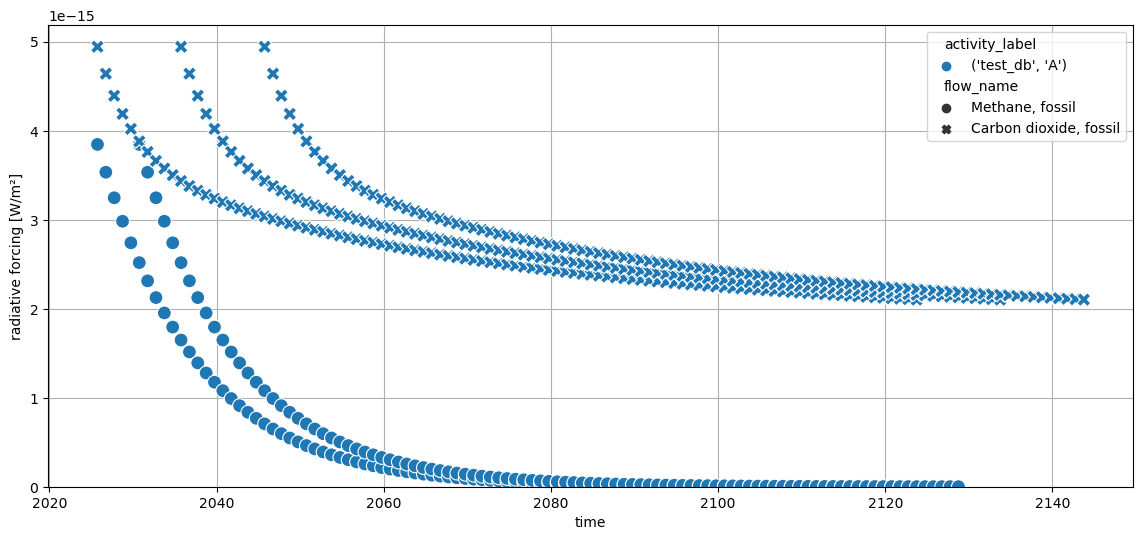

In [12]:
plot_dynamic_characterized_inventory(df_characterized, 
                                     time_horizon=100,
                                     metric="radiative_forcing",
                                     cumsum=False, 
                                     sum_emissions_within_activity=False, 
                                     sum_activities=False,
                                     activity_mapping_dict=lca.remapping_dicts["activity"],
                                     biosphere_mapping_dict=lca.remapping_dicts["biosphere"])

That's nice but what is the influence of our choices on the results? 

Let's play around with the parameters:

In [13]:
import ipywidgets as widgets
import matplotlib.pyplot as plt
from IPython.display import display
from matplotlib import style

def play_with_plot(time_horizon, metric, fixed_time_horizon):
    df_characterized = characterize(
        tl.df,
        metric=metric,
        base_lcia_method=method,
        time_horizon=time_horizon,
        fixed_time_horizon=fixed_time_horizon
    )
    
    plot_dynamic_characterized_inventory(
        df_characterized, 
        time_horizon=time_horizon,
        metric=metric,
        cumsum=False, 
        sum_emissions_within_activity=False, 
        sum_activities=False,
        activity_mapping_dict=lca.remapping_dicts["activity"],
        biosphere_mapping_dict=lca.remapping_dicts["biosphere"]
    )
    plt.show()
    return df_characterized

# Create a slider widget with adjusted width and margins for better readability
multiplier_slider = widgets.IntSlider(
    value=100,  
    min=1,    
    max=200,   
    step=1,  
    description='Time horizon:',
    layout=widgets.Layout(width='400px', margin='10px 0px 10px 0px') , # Adjust width and add margins
    style={'description_width': '150px'}  # Adjust description width
)

# Create a dropdown for metric with margins
dropdown_menu_metric = widgets.Dropdown(
    options=['radiative_forcing', 'GWP'],
    value='radiative_forcing',
    description='Select metric:',
    layout=widgets.Layout(width='300px', margin='10px 0px 10px 0px'),  # Adjust width and margins
    style={'description_width': '150px'}  # Adjust description width
)

# Create a dropdown for fixed time horizon with margins
dropdown_menu_fixed_time_horizon = widgets.Dropdown(
    options=[True, False],
    value=False,
    description='Apply fixed time horizon?',
    layout=widgets.Layout(width='300px', margin='10px 0px 10px 0px'),  # Adjust width and margins
    style={'description_width': '150px'}  # Adjust description width
)

# Display the interactive widget with the updated slider and dropdowns
interactive_plot = widgets.interactive(
    play_with_plot, 
    time_horizon=multiplier_slider, 
    metric=dropdown_menu_metric, 
    fixed_time_horizon=dropdown_menu_fixed_time_horizon
)

# Display the widget
display(interactive_plot)

interactive(children=(IntSlider(value=100, description='Time horizon:', layout=Layout(margin='10px 0px 10px 0p…

The optional arguments `fixed_time_horizon` can be used to apply Levasseur's approach of applying a fixed time horizon for all emissions.